## Task 0 

In [25]:
#!/usr/bin/env python3
"""This module creates the conv_forward function"""
import numpy as np


def conv_forward(A_prev, W, b, activation, padding="same", stride=(1, 1)):
    """
    Performs forward propagation over a convolutional layer of a neural 
    network
    
    Inputs:
    * A_prev - numpy.ndarray of shape (m, h_prev, w_prev, c_prev) 
        containing the output of the previous layer
        * m - number of examples
        * h_prev - height of the previous layer
        * w_prev - width of the previous layer
        * c_prev - number of channels in the previous layer
    * W - numpy.ndarray of shape (kh, kw, c_prev, c_new) 
        containing the kernels for the convolution
        * kh - filter height
        * kw - filter width
        * c_prev - number of channels in the previous layer
        * c_new - number of channels in the output
    * b - numpy.ndarray of shape (1, 1, 1, c_new) containing the 
        biases applied to the convolution
    * activation - activation function applied to the convolution
    * padding - string that is either same or valid, indicating the type of 
        padding used
    * stride - tuple of (sh, sw) containing the strides for the convolution
        * sh - stride for the height
        * sw - stride for the width

    Returns:
    Output of the convolutional layer
    """
    m, h_prev, w_prev, c_prev = A_prev.shape
    kh, kw, c_prev, c_new = W.shape
    sh, sw = stride

    if padding == "valid":
        ph, pw = 0, 0
    elif padding == "same":
        ph = (((h_prev - 1) * sh) + kh - h_prev) // 2
        pw = (((w_prev - 1) * sw) + kw - w_prev) // 2
    
    images = np.pad(A_prev, ((0, 0), (ph, ph), (pw, pw), (0, 0)))

    height = ((h_prev + (2 * ph) - kh) // sh) + 1
    weight = ((w_prev + (2 * pw) - kw) // sw) + 1
    
    conv_matrix = np.zeros((m, height, weight, c_new))
    
    for i in range(height):
        for j in range(weight):
            for k in range(c_new):
                v_start = i * sh
                v_end = v_start + kh
                h_start = j * sw
                h_end = h_start + kw
                kernel = W[:, :, :, k]
                output = np.multiply(images[:, v_start:v_end, h_start:h_end],
                                        kernel)
                conv_matrix[:, i, j, k] = (np.sum(output, axis=(1, 2, 3)))
    return activation(conv_matrix + b)

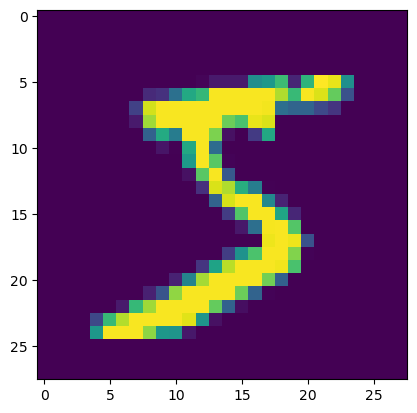

(50000, 26, 26, 2)


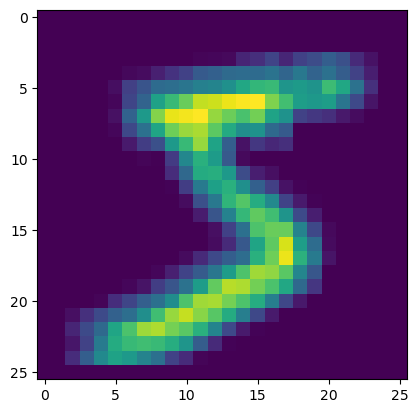

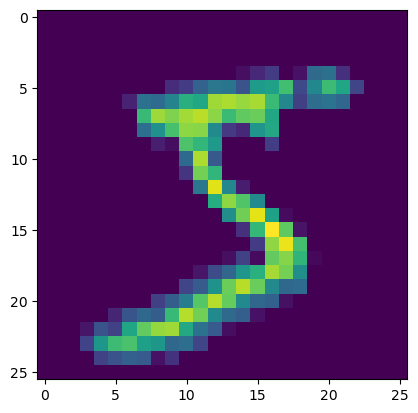

In [26]:
#!/usr/bin/env python3

import matplotlib.pyplot as plt
import numpy as np

if __name__ == "__main__":
    np.random.seed(0)
    lib = np.load('../data/MNIST.npz')
    X_train = lib['X_train']
    m, h, w = X_train.shape
    X_train_c = X_train.reshape((-1, h, w, 1))

    W = np.random.randn(3, 3, 1, 2)
    b = np.random.randn(1, 1, 1, 2)

    def relu(Z):
        return np.maximum(Z, 0)

    plt.imshow(X_train[0])
    plt.show()
    A = conv_forward(X_train_c, W, b, relu, padding='valid')
    print(A.shape)
    plt.imshow(A[0, :, :, 0])
    plt.show()
    plt.imshow(A[0, :, :, 1])
    plt.show()

## Task 1

In [27]:
#!/usr/bin/env python3
"""This module creates the pool_forward function"""
import numpy as np


def pool_forward(A_prev, kernel_shape, stride=(1, 1), mode='max'):
    """
    Performs forward propagation over a pooling layer of a neural network
    
    Inputs:
    * A_prev - numpy.ndarray of shape (m, h_prev, w_prev, c_prev) 
        containing the output of the previous layer
        * m - number of examples
        * h_prev - height of the previous layer
        * w_prev - width of the previous layer
        * c_prev - number of channels in the previous layer
    * kernel_shape is a tuple of (kh, kw) containing the size 
        of the kernel for the pooling 
        * kh - filter height
        * kw - filter width
    * stride - tuple of (sh, sw) containing the strides for the convolution
        * sh - stride for the height
        * sw - stride for the width
    * mode is a string containing either max or avg, indicating whether to 
        perform maximum or average pooling, respectively

    Returns:
    Output of the pooling layer
    """
    m, h_prev, w_prev, c_prev = A_prev.shape
    kh, kw = kernel_shape
    sh, sw = stride

    height = ((h_prev - kh) // sh) + 1
    weight = ((w_prev - kw) // sw) + 1
    
    conv_matrix = np.zeros((m, height, weight, c_prev))
    
    for i in range(height):
        for j in range(weight):
            v_start = i * sh
            v_end = v_start + kh
            h_start = j * sw
            h_end = h_start + kw

            output = A_prev[:, v_start:v_end, h_start:h_end, :]
            if mode == "max":
                conv_matrix[:, i, j, :] = np.max(output, axis=(1, 2))
            elif mode == "avg":
                conv_matrix[:, i, j, :] = np.mean(output, axis=(1, 2))

    return conv_matrix

(50000, 28, 28, 2)


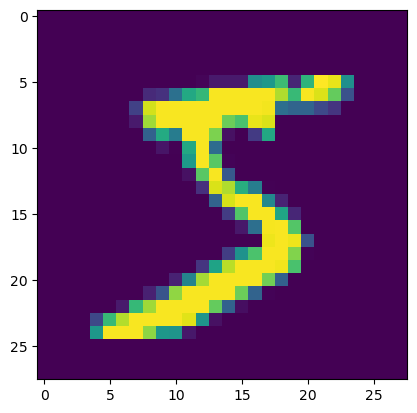

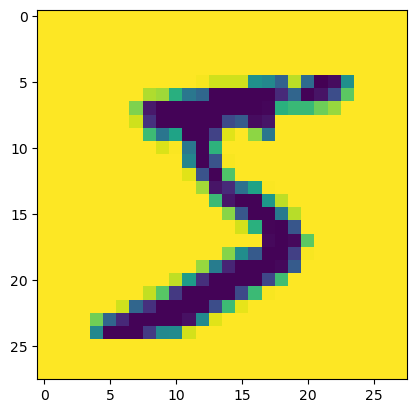

(50000, 14, 14, 2)


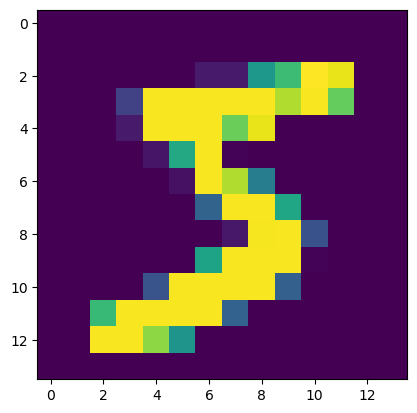

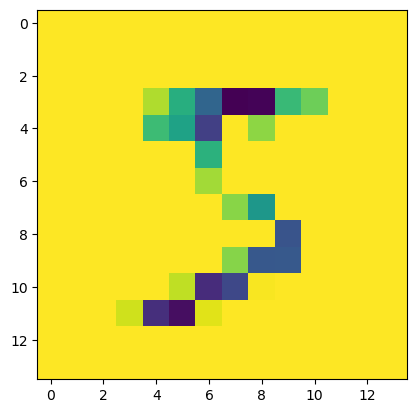

In [29]:
#!/usr/bin/env python3

import matplotlib.pyplot as plt
import numpy as np

if __name__ == "__main__":
    np.random.seed(0)
    lib = np.load('../data/MNIST.npz')
    X_train = lib['X_train']
    m, h, w = X_train.shape
    X_train_a = X_train.reshape((-1, h, w, 1))
    X_train_b = 1 - X_train_a
    X_train_c = np.concatenate((X_train_a, X_train_b), axis=3)

    print(X_train_c.shape)
    plt.imshow(X_train_c[0, :, :, 0])
    plt.show()
    plt.imshow(X_train_c[0, :, :, 1])
    plt.show()
    A = pool_forward(X_train_c, (2, 2), stride=(2, 2))
    print(A.shape)
    plt.imshow(A[0, :, :, 0])
    plt.show()
    plt.imshow(A[0, :, :, 1])
    plt.show()

## Task 2

In [45]:
#!/usr/bin/env python3
"""This module creates the conv_backward function"""
import numpy as np


def conv_backward(dZ, A_prev, W, b, padding="same", stride=(1, 1)):
    """
    Performs back propagation over a convolutional layer of a neural 
    network
    
    Inputs:
    * dZ - numpy.ndarray of shape (m, h_new, w_new, c_new) containing the
        partial derivatives with respect to the unactivated output of the
        convolutional layer
        * m - number of examples
        * h_new - height of the output
        * w_new - width of the output
        * c_new - number of channels in the output
    * A_prev - numpy.ndarray of shape (m, h_prev, w_prev, c_prev) 
        containing the output of the previous layer
        * m - number of examples
        * h_prev - height of the previous layer
        * w_prev - width of the previous layer
        * c_prev - number of channels in the previous layer
    * W - numpy.ndarray of shape (kh, kw, c_prev, c_new) 
        containing the kernels for the convolution
        * kh - filter height
        * kw - filter width
        * c_prev - number of channels in the previous layer
        * c_new - number of channels in the output
    * b - numpy.ndarray of shape (1, 1, 1, c_new) containing the 
        biases applied to the convolution
    * padding - string that is either same or valid, indicating the type of 
        padding used
    * stride - tuple of (sh, sw) containing the strides for the convolution
        * sh - stride for the height
        * sw - stride for the width

    Returns:
    Partial derivatives with respect to the previous layer (dA_prev),
    the kernels (dW), and the biases (db), respectively
    """
    m, h_new, w_new, c_new = dZ.shape
    m, h_prev, w_prev, c_prev = A_prev.shape
    kh, kw, c_prev, c_new = W.shape
    sh, sw = stride

    if padding == "valid":
        ph, pw = 0, 0
    elif padding == "same":
        ph = (((h_prev - 1) * sh) + kh - h_prev) // 2 + 1
        pw = (((w_prev - 1) * sw) + kw - w_prev) // 2 + 1
    
    padded_image = np.pad(A_prev, ((0, 0), (ph, ph), (pw, pw), (0, 0)))
    dA_prev = np.zeros((m, h_prev + (2 * ph), w_prev + (2 * pw), c_prev))
    dW = np.zeros((kh, kw, c_prev, c_new))
    db = np.sum(dZ, axis=(0, 1, 2), keepdims=True)

    for i in range(m):
        for j in range(c_new):
            for k in range(h_new):
                for l in range(w_new):
                    v_start = k * sh
                    v_end = v_start + kh
                    h_start = l * sw
                    h_end = h_start + kw
                    padded_slice = padded_image[i, v_start:v_end, h_start:h_end, :]
                    dA_prev[i, v_start:v_end, h_start:h_end, :] += W[:, :, :, j] * dZ[i, k, l, j]
                    dW[:, :, :, j] += padded_slice * dZ[i, k, l, j]
    if padding == "same":
        dA_prev = dA_prev[:, ph:-ph, pw:-pw, :]
    return dA_prev, dW, db

In [46]:
#!/usr/bin/env python3

import numpy as np

if __name__ == "__main__":
    np.random.seed(0)
    lib = np.load('../data/MNIST.npz')
    X_train = lib['X_train']
    _, h, w = X_train.shape
    X_train_c = X_train[:10].reshape((-1, h, w, 1))

    W = np.random.randn(3, 3, 1, 2)
    b = np.random.randn(1, 1, 1, 2)

    dZ = np.random.randn(10, h - 2, w - 2, 2)
    print(conv_backward(dZ, X_train_c, W, b, padding="valid"))

(array([[[[-4.24205748],
         [ 0.19390938],
         [-2.80168847],
         ...,
         [-2.93059274],
         [-0.74257184],
         [ 1.23556676]],

        [[-1.00865794],
         [ 0.24929631],
         [ 2.99153975],
         ...,
         [ 0.43357888],
         [ 4.96415936],
         [-0.44667327]],

        [[-1.87909273],
         [-1.52898354],
         [-1.03988664],
         ...,
         [-2.08719794],
         [ 0.72118428],
         [ 0.43712847]],

        ...,

        [[-1.85981381],
         [-4.35543293],
         [ 3.57636107],
         ...,
         [ 2.11136296],
         [ 0.53958723],
         [-3.52000282]],

        [[-1.0499573 ],
         [-2.04696766],
         [-3.65137871],
         ...,
         [-0.52756967],
         [-0.08825488],
         [ 0.62158883]],

        [[-0.33383597],
         [-0.68426308],
         [-1.16737412],
         ...,
         [ 0.38028383],
         [ 0.90910959],
         [ 1.1018034 ]]],


       [[[ 1.3242862 ],

## Task 3

In [58]:
#!/usr/bin/env python3
"""This module creates the pool_backward function"""
import numpy as np


def pool_backward(dA, A_prev, kernel_shape, stride=(1, 1), mode='max'):
    """
    Performs back propagation over a pooling layer of a neural network

    Inputs:
    * dA - numpy.ndarray of shape (m, h_new, w_new, c) containing the
        partial derivatives with respect to the output of the pooling layer
        * m - number of examples
        * h_new - height of the output
        * w_new - width of the output
        * c - number of channels
    * A_prev - numpy.ndarray of shape (m, h_prev, w_prev, c_prev)
        containing the output of the previous layer
        * m - number of examples
        * h_prev - height of the previous layer
        * w_prev - width of the previous layer
        * c_prev - number of channels in the previous layer
    * kernel_shape is a tuple of (kh, kw) containing the size
        of the kernel for the pooling
        * kh - filter height
        * kw - filter width
    * stride - tuple of (sh, sw) containing the strides for the convolution
        * sh - stride for the height
        * sw - stride for the width
    * mode is a string containing either max or avg, indicating whether to
        perform maximum or average pooling, respectively

    Returns:
    Output of the pooling layer
    """
    m, h_new, w_new, c = dA.shape
    m, h_prev, w_prev, c_prev = A_prev.shape
    kh, kw = kernel_shape
    sh, sw = stride

    dA_prev = np.zeros((m, h_prev, w_prev, c))
    for ex in range(m):
        for kernel_index in range(c):
            for h in range(h_new):
                for w in range(w_new):
                    i = h * sh
                    j = w * sw
                    if mode is 'max':
                        pool = A_prev[ex, i: i + kh, j: j + kw, kernel_index]
                        mask = np.where(pool == np.max(pool), 1, 0)
                    elif mode is 'avg':
                        mask = np.ones((kh, kw))
                        mask /= (kh * kw)
                    dA_prev[ex, i: i + kh, j: j + kw, kernel_index] += (
                        mask * dA[ex, h, w, kernel_index])
    return dA_prev

In [59]:
#!/usr/bin/env python3

import numpy as np

if __name__ == "__main__":
    np.random.seed(0)
    lib = np.load('../data/MNIST.npz')
    X_train = lib['X_train']
    _, h, w = X_train.shape
    X_train_a = X_train[:10].reshape((-1, h, w, 1))
    X_train_b = 1 - X_train_a
    X_train_c = np.concatenate((X_train_a, X_train_b), axis=3)

    dA = np.random.randn(10, h // 3, w // 3, 2)
    print(pool_backward(dA, X_train_c, (3, 3), stride=(3, 3)))

[[[[ 1.76405235  0.40015721]
   [ 1.76405235  0.40015721]
   [ 1.76405235  0.40015721]
   ...
   [ 1.49407907 -0.20515826]
   [ 1.49407907 -0.20515826]
   [ 0.          0.        ]]

  [[ 1.76405235  0.40015721]
   [ 1.76405235  0.40015721]
   [ 1.76405235  0.40015721]
   ...
   [ 1.49407907 -0.20515826]
   [ 1.49407907 -0.20515826]
   [ 0.          0.        ]]

  [[ 1.76405235  0.40015721]
   [ 1.76405235  0.40015721]
   [ 1.76405235  0.40015721]
   ...
   [ 1.49407907 -0.20515826]
   [ 1.49407907 -0.20515826]
   [ 0.          0.        ]]

  ...

  [[ 2.38314477  0.94447949]
   [ 2.38314477  0.94447949]
   [ 2.38314477  0.94447949]
   ...
   [-0.49803245  1.92953205]
   [-0.49803245  1.92953205]
   [ 0.          0.        ]]

  [[ 2.38314477  0.94447949]
   [ 2.38314477  0.94447949]
   [ 2.38314477  0.94447949]
   ...
   [-0.49803245  1.92953205]
   [-0.49803245  1.92953205]
   [ 0.          0.        ]]

  [[ 0.          0.        ]
   [ 0.          0.        ]
   [ 0.          0. 

## Task 4

In [70]:
#!/usr/bin/env python3
"""This module creates the lenet5 function"""
import tensorflow.compat.v1 as tf


def lenet5(x, y):
    """
    Builds a modified version of the LeNet-5 architecture using tensorflow

    Inputs:
    * x is a tf.placeholder of shape (m, 28, 28, 1) 
        containing the input images for the network
        * m is the number of images
    * y is a tf.placeholder of shape (m, 10) containing the one-hot

    Returns:
    Output of the pooling layer
    """
    init = tf.keras.initializers.VarianceScaling(scale=2.0)
    
    conv_layer1 = tf.layers.conv2d(inputs=x,
                                      filters=6,
                                      kernel_size=(5, 5),
                                      padding='same',
                                      activation='relu',
                                      kernel_initializer=init)

    max_pool1 = tf.layers.max_pooling2d(inputs=conv_layer1,
                                           pool_size=(2, 2),
                                           strides=(2, 2))

    conv_layer2 = tf.layers.conv2d(inputs=max_pool1,
                                      filters=16,
                                      kernel_size=(5, 5),
                                      padding='valid',
                                      activation='relu',
                                      kernel_initializer=init)

    max_pool2 = tf.layers.max_pooling2d(inputs=conv_layer2,
                                           pool_size=(2, 2),
                                           strides=(2, 2))

    flat_pool = tf.layers.flatten(max_pool2)

    FC1 = tf.layers.dense(inputs=flat_pool,
                                        units=120,
                                        activation='relu',
                                        kernel_initializer=init,
                                        )

    FC2 = tf.layers.dense(inputs=FC1,
                                        units=84,
                                        activation='relu',
                                        kernel_initializer=init,
                                        )

    FC3 = tf.layers.dense(inputs=FC2,
                                        units=10,
                                        kernel_initializer=init)

    softmax = tf.nn.softmax(FC3)

    loss = tf.losses.softmax_cross_entropy(onehot_labels=y,
                                           logits=FC3)

    optimizer = tf.train.AdamOptimizer().minimize(loss)

    y_max = tf.math.argmax(y, axis=1)
    y_pred_max = tf.math.argmax(FC3, axis=1)
    equality = tf.math.equal(y_max, y_pred_max)
    accuracy = tf.math.reduce_mean(tf.cast(equality, tf.float32))

    return softmax, optimizer, loss, accuracy

In [71]:
#!/usr/bin/env python3

import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

if __name__ == "__main__":
    np.random.seed(0)
    tf.set_random_seed(0)
    lib = np.load('../data/MNIST.npz')
    X_train = lib['X_train']
    Y_train = lib['Y_train']
    X_valid = lib['X_valid']
    Y_valid = lib['Y_valid']
    m, h, w = X_train.shape
    X_train_c = X_train.reshape((-1, h, w, 1))
    X_valid_c = X_valid.reshape((-1, h, w, 1))
    x = tf.placeholder(tf.float32, (None, h, w, 1))
    y = tf.placeholder(tf.int32, (None,))
    y_oh = tf.one_hot(y, 10)
    y_pred, train_op, loss, acc = lenet5(x, y_oh)
    batch_size = 32
    epochs = 10
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(epochs):
            cost, accuracy = sess.run((loss, acc), feed_dict={x:X_train_c, y:Y_train})
            cost_valid, accuracy_valid = sess.run((loss, acc), feed_dict={x:X_valid_c, y:Y_valid})
            print("After {} epochs: {} cost, {} accuracy, {} validation cost, {} validation accuracy".format(epoch, cost, accuracy, cost_valid, accuracy_valid))
            p = np.random.permutation(m)
            X_shuffle = X_train_c[p]
            Y_shuffle = Y_train[p]
            for i in range(0, m, batch_size):
                X_batch = X_shuffle[i:i+batch_size]
                Y_batch = Y_shuffle[i:i+batch_size]
                sess.run(train_op, feed_dict={x:X_batch, y:Y_batch})
        cost, accuracy = sess.run((loss, acc), feed_dict={x:X_train_c, y:Y_train})
        cost_valid, accuracy_valid = sess.run((loss, acc), feed_dict={x:X_valid_c, y:Y_valid})
        print("After {} epochs: {} cost, {} accuracy, {} validation cost, {} validation accuracy".format(epochs, cost, accuracy, cost_valid, accuracy_valid))
        Y_pred = sess.run(y_pred, feed_dict={x:X_valid_c, y:Y_valid})
        print(Y_pred[0])
        Y_pred = np.argmax(Y_pred, 1)
        plt.imshow(X_valid[0])
        plt.title(str(Y_valid[0]) + ' : ' + str(Y_pred[0]))
        plt.show()

/var/folders/rx/tppkmy112v167ctfjx_pw6y80000gn/T/ipykernel_23481/1308174587.py:21: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv_layer1 = tf.layers.conv2d(inputs=x,
/var/folders/rx/tppkmy112v167ctfjx_pw6y80000gn/T/ipykernel_23481/1308174587.py:28: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  max_pool1 = tf.layers.max_pooling2d(inputs=conv_layer1,
/var/folders/rx/tppkmy112v167ctfjx_pw6y80000gn/T/ipykernel_23481/1308174587.py:32: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  conv_layer2 = tf.layers.conv2d(inputs=max_pool1,
/var/folders/rx/tppkmy112v167ctfjx_pw6y80000gn/T/ipykernel_23481/1308174587.py:39: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `t

After 0 epochs: 2.945556879043579 cost, 0.09831999987363815 accuracy, 2.9643120765686035 validation cost, 0.10159999877214432 validation accuracy
After 1 epochs: 0.1952628195285797 cost, 0.956279993057251 accuracy, 0.18155814707279205 validation cost, 0.9614999890327454 validation accuracy
After 2 epochs: 2.6232993602752686 cost, 0.946899950504303 accuracy, 2.3597750663757324 validation cost, 0.9526000022888184 validation accuracy


KeyboardInterrupt: 

## Task 5

In [6]:
#!/usr/bin/env python3
"""This module creates the lenet5 function"""
import tensorflow.keras as K
import numpy as np


def lenet5(X):
    """
    Builds a modified version of the LeNet-5 architecture using Keras

    Inputs:
    * X is a tf.placeholder of shape (m, 28, 28, 1) 
        containing the input images for the network
        * m is the number of images

    Returns:
    K.Model compiled to use Adam optimization 
    (with default hyperparameters) and accuracy metrics
    """
    init = K.initializers.he_normal()

    conv_layer1 = K.layers.Conv2D(filters=6, kernel_size=5,
                            padding='same', activation='relu',
                            kernel_initializer=init)(X)
    
    max_pool1 = K.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(conv_layer1)

    conv_layer2 = K.layers.Conv2D(filters=16, kernel_size=5,
                            padding='valid', activation='relu',
                            kernel_initializer=init)(max_pool1)
    
    max_pool2 = K.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(conv_layer2)

    flatten = K.layers.Flatten()(max_pool2)

    FC1 = K.layers.Dense(units=120, activation='relu',
                         kernel_initializer=init)(flatten)

    FC2 = K.layers.Dense(units=84, activation='relu',
                         kernel_initializer=init)(FC1)
    
    FC3 = K.layers.Dense(units=10, kernel_initializer=init,
                         activation='softmax')(FC2)

    model = K.models.Model(X, FC3)

    adam = K.optimizers.Adam()

    model.compile(optimizer=adam, loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

/Users/ezalta/anaconda3/lib/python3.11/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/5


2024-03-03 17:47:49.852080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - ETA: 0s - loss: 0.4711 - accuracy: 0.8639

2024-03-03 17:48:05.710756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - 18s 11ms/step - loss: 0.4711 - accuracy: 0.8639 - val_loss: 0.2756 - val_accuracy: 0.9212
Epoch 2/5
1563/1563 [==============================] - 17s 11ms/step - loss: 0.4575 - accuracy: 0.8763 - val_loss: 0.4775 - val_accuracy: 0.8760
Epoch 3/5
1563/1563 [==============================] - 17s 11ms/step - loss: 0.4871 - accuracy: 0.8618 - val_loss: 0.6536 - val_accuracy: 0.8147
Epoch 4/5
1563/1563 [==============================] - 17s 11ms/step - loss: 0.5019 - accuracy: 0.8419 - val_loss: 0.3866 - val_accuracy: 0.8806
Epoch 5/5
107/313 [=========>....................] - ETA: 0s

2024-03-03 17:49:15.480518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 0s 1ms/step
[1.7696941e-05 2.4408905e-03 5.5508944e-03 9.8028320e-01 4.9952714e-06
 3.6410577e-04 1.2589905e-03 3.4811058e-07 1.0073481e-02 5.3124149e-06]


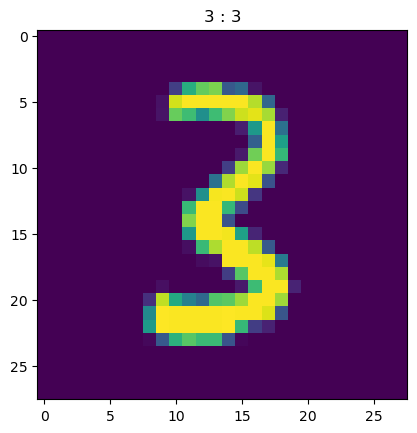

In [7]:
#!/usr/bin/env python3
"""
Main file
"""
# Force Seed - fix for Keras
SEED = 0
import matplotlib.pyplot as plt
import os
os.environ['PYTHONHASHSEED'] = str(SEED)
import random
random.seed(SEED)
import numpy as np
np.random.seed(SEED)
import tensorflow as tf
tf.random.set_seed(SEED)
import tensorflow.keras as K


if __name__ == "__main__":
    lib = np.load('../data/MNIST.npz')
    X_train = lib['X_train']
    m, h, w = X_train.shape
    X_train_c = X_train.reshape((-1, h, w, 1))
    Y_train = lib['Y_train']
    Y_train_oh = K.utils.to_categorical(Y_train, num_classes=10)
    X_valid = lib['X_valid']
    X_valid_c = X_valid.reshape((-1, h, w, 1))
    Y_valid = lib['Y_valid']
    Y_valid_oh = K.utils.to_categorical(Y_valid, num_classes=10)
    X = K.Input(shape=(h, w, 1))
    model = lenet5(X)
    batch_size = 32
    epochs = 5
    model.fit(X_train_c, Y_train_oh, batch_size=batch_size, epochs=epochs,
                       validation_data=(X_valid_c, Y_valid_oh))
    Y_pred = model.predict(X_valid_c)
    print(Y_pred[0])
    Y_pred = np.argmax(Y_pred, 1)
    plt.imshow(X_valid[0])
    plt.title(str(Y_valid[0]) + ' : ' + str(Y_pred[0]))
    plt.show()